# 取込みと変換にデータパイプラインを使用

このワークフローは、DataRobotに登録されたデータセットを最新の状態に保ち、実験、バッチ予測、または自動再トレーニングジョブの準備ができるように、再利用可能なデータパイプラインの構築方法を示しています。DataRobotのPythonクライアントと一部の設定済み環境変数を活用して、スケジュールできるだけでなく、同様の接続を使用して、より多くのデータセットを取込み、準備するためのテンプレートとしても使用できるパイプラインを生成します。

この例では、Snowflakeに既存の接続がすでに設定されており、資格情報がDataRobot内に保存されていると仮定します。 [データストアへの接続の作成](https://docs.datarobot.com/en/docs/data/connect-data/data-conn.html)については、ドキュメントを参照してください。または、このワークフローをガイドとして使用して、APIまたはその他のプログラムによるツールを介して収集されたデータを変換およびカタログ化することもできます。

## データパイプラインとは？

データパイプラインは、分析用のデータを設定する一連の処理タスクです。組織は、さまざまなソースから収集された大量の未処理のデータを蓄積でき、そのデータに対して分析を実行することを目的としますが、その元のデータは役に立たないことがよくあります。データを効率的にするには、データを移動、ソート、フィルター、再フォーマット、分析する必要があります。データパイプラインには、データのパターンを識別および分析してアクションを通知するツールが含まれています。たとえば、データパイプラインがデータを準備し、データを調べた後でデータから値を抽出できる場合があります。

### 環境変数を追加

DataRobotでデータストアの接続と資格情報が利用可能であると仮定すると、DataRobot Notebooksで次のシークレットを提供することができます。詳細については、 [環境変数の追加](https://docs.datarobot.com/en/docs/dr-notebooks/code-nb/dr-env-nb.html#environment-variables)に関するドキュメントを参照してください。

| 変数 | 説明 |
| --- | :----------- |
| `connection_name` | DataRobotの [接続オブジェクト](https://app.datarobot.com/account/data-connections)の名前。 |
| `credential_name` | DataRobotの [資格情報オブジェクト](https://app.datarobot.com/account/credentials-management)の名前。 |
| `datasource_name` | 指定された接続を介してデータのクエリーに使用されるデータソースオブジェクトの名前（これは事前に作成する必要はなく、任意の文字列にすることができます）。 |
| `ingest_table_name` | 取込みたいターゲットデータストアのテーブルの名前。 |
| `raw_dataset_name` | 元のデータを含むカタログアイテムの名前（これは事前に作成する必要はなく、任意の文字列にすることができます*） |
| `transform_dataset_name` | 最終的に変換されたデータを含むカタログアイテムの名前（これは事前に作成する必要はなく、任意の文字列にすることができます）。 |

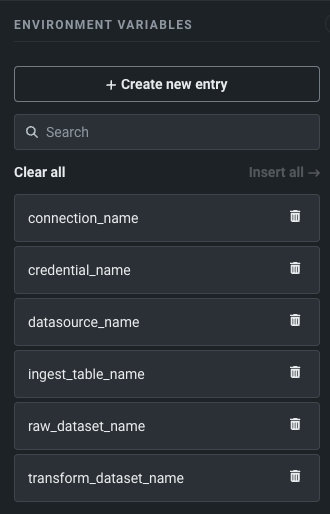

### ライブラリのインポート

In [ ]:
import datarobot as dr
import os

ingest_table_name = os.environ['ingest_table_name']
connection_name = os.environ['connection_name']
datasource_name = os.environ['datasource_name']
transform_dataset_name = os.environ['transform_dataset_name']
raw_dataset_name = os.environ['raw_dataset_name']
credential_name = os.environ['credential_name']

### データソースを収集または作成

このセルは、環境変数に指定された名前で、適切なデータアーティファクトを検索します。接続と資格情報が必要であり、使用できない場合は例外が発生します。データソースオブジェクトがまだ作成されていない場合、ターゲット取込みテーブルを取得するためのクエリーを含む新しいオブジェクトが作成されます。

In [ ]:
try:
    connection = [c for c in dr.DataStore.list() if connection_name in c.canonical_name][0]
except:
    raise Exception("Specified connection is not configured.")

try:
    credential = [c for c in dr.Credential.list() if credential_name in c.name][0]
except:
    raise Exception("Specified credential is not configured.")

try:
    datasource = [s for s in dr.DataSource.list() if datasource_name in s.canonical_name][0]
except:
    query_train = ("SELECT * FROM " + ingest_table_name)
    ds_params = dr.DataSourceParameters(data_store_id=connection.id, query=query_train)
    datasource = dr.DataSource.create(data_source_type="jdbc", canonical_name=datasource_name, params=ds_params)

### 元のデータの収集

次に、元のデータをDataRobotのAIカタログに読込みます。名前付きデータセットがすでに存在する場合、パイプラインは既存のオブジェクトに新しいバージョンを追加します。

In [ ]:
try:
    raw_dataset = [x for x in dr.Dataset.list() if raw_dataset_name in x.name][0]
    raw_dataset = dr.Dataset.create_version_from_data_source(raw_dataset.id, data_source_id=datasource.id, credential_id=credential.credential_id)
except:
    raw_dataset = dr.Dataset.create_from_data_source(data_source_id=datasource.id, do_snapshot=True, credential_id=credential.credential_id)
    raw_dataset.modify(name=raw_dataset_name)

### データの変換

ここでデータ変換を実行できます。元のデータはデータフレームに読み込まれ、必要に応じて操作し、その後、最終的なデータセットでカタログを更新します。

In [ ]:
df = raw_dataset.get_as_dataframe()
df.drop(['policy_code', 'title', 'zip_code'], axis=1, inplace=True)
df = df.astype({"revol_bal": int, "revol_util": float})

### 変換されたデータを保存

変換されたデータをAIカタログに追加して、下位のタスクで使用できるようにします。

In [ ]:
try:
    transformed_dataset = [x for x in dr.Dataset.list() if transform_dataset_name in x.name][0]
    transformed_dataset = dr.Dataset.create_version_from_in_memory_data(transformed_dataset.id, df)
except:
    transformed_dataset = dr.Dataset.create_from_in_memory_data(df)
    transformed_dataset.modify(name=transform_dataset_name)

### スケジューリングと将来の使用

DataRobot Notebooksは、ユースケースに適した間隔で実行するように [スケジュール](https://docs.datarobot.com/en/docs/workbench/wb-notebook/wb-manage-nb/wb-schedule-nb.html#notebook-scheduling)できます。ノートブックのスケジューリングでは、設定された環境変数を他のジョブの [パラメーターとしてオーバーライド](https://docs.datarobot.com/en/docs/workbench/wb-notebook/wb-manage-nb/wb-schedule-nb.html#notebook-parameterization)できるため、同じ変換が必要な場合、他のテーブルを簡単に取込むことができます。

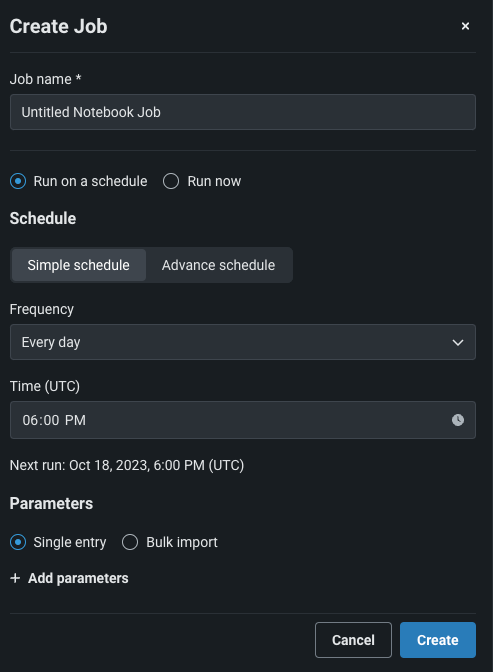